# Mini-Lab: Logistic Regression and SVM's

## 1. Creating a Logistic Regression and Support Vector Machine Model

### <u>Introduction</u>

The objective of this mini lab is to build and evaluate two classifciation models to predict a student's placement status based on various academic, techincal, and personal attributes. The dataset, Student Placement, is hosted on Kaggle and contains features such as CGPA, communication skills, coding skills, certification, and backlog count.

The two supervised learning algorithms used for this lab were Logistic Regression and Support Vector Machines (SVM). Logistic Regression models primarly serves as baseline due to its simplicity and effectiveness on lineary seperable data. Whereas, SVM models have a higher ability to handle linear and non-linear decision boundaries.
 
The lab follows a sturctured machine learning workflow, which includes data preprocessing, feature enginerring, model traning, evaluation using an 80/20 train-test split, and tuning the paramters to improve model performance. Model performance is assessed using accuracy and confusion matrices to understand classification behaviors across classes. Additionally, feature importance analysis is used to determine whether reducing the feature set improves performance and interpretablitiy. 

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression 
from sklearn import metrics as mt

In [7]:
#loading dataset

df = pd.read_csv("../Student Placement Dataset/full_dataset.csv")
print(df.shape)
df.head()             

(50000, 15)


,Student_ID,Age,Gender,Degree,Branch,CGPA,Internships,Projects,Coding_Skills,Communication_Skills,Aptitude_Test_Score,Soft_Skills_Rating,Certifications,Backlogs,Placement_Status
0,1048,22,Female,B.Tech,ECE,6.29,0,3,4,6,51,5,1,3,Not Placed
1,37820,20,Female,BCA,ECE,6.05,1,4,6,8,59,8,2,1,Not Placed
2,49668,22,Male,MCA,ME,7.22,1,4,6,6,58,6,2,2,Not Placed
3,19467,22,Male,MCA,ME,7.78,2,4,6,6,90,4,2,0,Placed
4,23094,20,Female,B.Tech,ME,7.63,1,4,6,5,79,6,2,0,Placed


### <u>Data Preprocessing and Feature Engineering</u>

Before trainig the models, several preprocessing steps were applied to prepare the dataset for classification. Firstly, the attribute, Student_ID, was removed as its only purpose is to serve as a unique indentifier and it does not provide any predicitive value for determining placement status. Secondly, missing values were handled using a group-based imputation strategy which grouped Degree and Branch, under the assumption that students enrolled in the same academic program share similar charactersitics. Additionally, numerical feature were imputed using the median in each group to reduce the influence of outleirs, while categorical features were imputed usimg the group mode to preserve the most frequent occuring category in each group. 

After imputation, the numerical and categorical features were recombined into a single dataset, and the grouped values were restored to ensure consistency. Additionally, a new variable called cgpa_range was created by discretizing the continuous CGPA variable in ordinal bins to allow the model to capture non-linear relationships bewteen academic performance and placement outcomes. Lastly, any remaining observations which contained missing values were removed to ensure that the final dataset was complete and ready for feature encoding and model training. 

In [8]:
#dropping ID 
df.drop(columns = ["Student_ID"], errors= 'ignore')

#identifying numeric and categorical columns
numeric_columns = df.select_dtypes(include=[np.number]).columns
categorical_columns = df.select_dtypes(include=['object']).columns

#impute numeric columns using group median 
df_imputed = df.copy()

for col in numeric_columns:
    df_imputed[col] = (
        df.groupby(['Degree', 'Branch'])[col]
        .transform(lambda x: x.fillna(x.median()))
    )

# impute categorical columns using group mode
for col in categorical_columns:
    df_imputed[col] = (
        df.groupby(['Degree', 'Branch'])[col]
        .transform(lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x)
    )

# Create CGPA  with the newest values
df_imputed['cgpa_range'] = pd.cut(
    df_imputed['CGPA'],
    bins=[0, 5.5, 7.0, 8.5, 10.01],
    labels=[0, 1, 2, 3],
    include_lowest=True
)

df_imputed['cgpa_range'] = df_imputed['cgpa_range'].astype(int)


#drop rows with missing values
df_imputed = df_imputed.dropna(subset=['Placement_Status'])

### <u>Train-Test Split and Feature Encoding</u>

Within this section, categorical variables were converted into numerical values using one-hot encoding to ensure it is compatiable with machine learning algorithms. Therefore, the variables Gender, Degree, and Branch were encoded using the dummy variables, and the first category was also dropped to avoid multicollinearity. Then the dataset was seperated into feature matrix X, which contains all the predictor variables, and target variable y which represented the placement stautus.

To evaluate the model performance, and 80/20 train-test split was implemented using the ShuffleSplit cross-validation method. This method randomly shuffles and split the data into the training and testing sets three seperate times, with 20% of the data saved for testing in each iteration. The printed output confirms that the configuration of the cross validation object, and displays that the multiple randomized train-test splits were generated. 
    

In [9]:
#train/test split

#performing one hot encoding on categorical data
df_encoded = pd.get_dummies(df_imputed, columns=['Gender', 'Degree', 'Branch'], drop_first=True)
                                          
#predict the X and y data
y = df_encoded['Placement_Status'].values
X = df_encoded.drop(columns=['Placement_Status']).values

#CV 
cv_object = ShuffleSplit(n_splits =3, test_size = 0.2, random_state=14)

print(cv_object)

ShuffleSplit(n_splits=3, random_state=14, test_size=0.2, train_size=None)


### <u>Logistic Regression with All Features</u>

A logisitc regression model was trained with all features in the dataset to establish a baseline classification performance. The model was created using the logistic regression function wih an L2 regularization strenght of C=1.0, and the liblinear solver. Additionally, all features were standarized to have a mean of zero and a unit variance, which is crucial for logistic regression to ensure that features measured on different scales contribute equally to the model. 

The model evaluation was performed using ShuffleSplit cross validation stragey, which resulted in three 80/20 train-test splits. Therefore, these three iterations achieved accuracy values of 86.8%, 87.4%, and 86.7%. This indicated stable performances across the different random splits of data. Additionally, the confusion matrices showed that each model classified a large proportion of both placed and not-placed studnets with more false negatives than false positives. Therefore, overall, these results demonstrated that the logistic regression performs realiably on datasets using all features. 

In [10]:
# logistic regression with all features

#creating logistic regression object with diff learning paramaters and constants
lr_clf = LogisticRegression(C=1.0, class_weight=None, solver= 'liblinear')


#training loop 
iter_num=0
for train_idx, test_idx in cv_object.split(X,y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]


    #standarizing features to have mean = 0 & sd =1
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    #train the lr model on the training data
    lr_clf.fit(X_train_scaled, y_train)
    y_hat = lr_clf.predict(X_test_scaled)

    #evaluate
    accuracy = mt.accuracy_score(y_test, y_hat)
    conf = mt.confusion_matrix(y_test, y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", accuracy )
    print("confusion matrix\n",conf)
    iter_num+=1

====Iteration 0  ====
accuracy 0.8678
confusion matrix
 [[5770  611]
 [ 711 2908]]
====Iteration 1  ====
accuracy 0.8735
confusion matrix
 [[5804  612]
 [ 653 2931]]
====Iteration 2  ====
accuracy 0.8663
confusion matrix
 [[5691  649]
 [ 688 2972]]


### <u>Logistic Regression with Important Features</u>

In this section, logistic regression model was applied to a reduced set of features identified as most important in the previous lab, and its performance was compared to that of the full-feature model. These features included communication skills, backlog count, CGPA, coding skills, number of projects, certifications, and aptitude test score. The dataset which included these predictors and placement status was split into training and testing sets using an 80/20 ShuffleSplit strategy to maintain consistency with earlier experiments. 

All features were again standarized, and logistic regression classifier with L2 regularization along with the liblinear solver was trained on the reduced set. The result achieved an accuracy of 86.7%, which is almost identical to the previous model trained on all features. 
    
Below, the confusion matrix indicates that the model correctly classified a large proportion of both placed and not-placed students, in a similar baseline of false positives and false negatives as the full logistic regression model did. Therefore, these results show that the reduced feature set preserves most of the predicitive power of the full dataset while improving model simplicity and interpretability. 

df_top shape: (50000, 8)
Logistic Regression Accuracy (important features): 0.8673


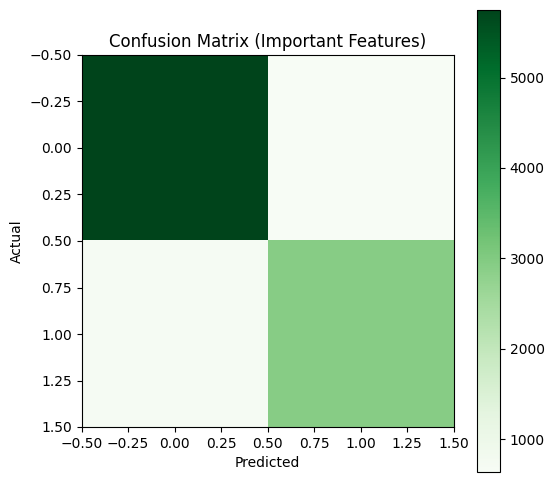

In [11]:
import matplotlib.pyplot as plt
#running the logisitic regression with the chosen/important features
# top features chosen from last lab

top_features = [
    'Communication_Skills',
    'Backlogs',
    'CGPA',
    'Coding_Skills',
    'Projects',
    'Certifications',
    'Aptitude_Test_Score'
]

#check
df_top = df_encoded[top_features + ['Placement_Status']]
print("df_top shape:", df_top.shape)

# split the features and labels
X = df_top.drop(columns=['Placement_Status']).values
y = df_top['Placement_Status'].values

# 3. CV
cv = ShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# 4. Logistic Regression model 
lr_clf = LogisticRegression(
    penalty='l2',
    C=1.0,
    solver='liblinear',  # or 'lbfgs' if you prefer
    max_iter=1000
)

#Train/test loop
scaler = StandardScaler()


for train_idx, test_idx in cv.split(X, y):
    X_train = X[train_idx]
    y_train = y[train_idx]
    X_test = X[test_idx]
    y_test = y[test_idx]

    # Standardize features
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train model
    lr_clf.fit(X_train_scaled, y_train)

    # Predict
    y_hat = lr_clf.predict(X_test_scaled)

    # Evaluate
    acc = mt.accuracy_score(y_test, y_hat)
    conf = mt.confusion_matrix(y_test, y_hat)


print(f"Logistic Regression Accuracy (important features): {acc:.4f}")

plt.figure(figsize=(6, 6))
plt.imshow(conf, cmap='Greens')
plt.title("Confusion Matrix (Important Features)")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### <u>Logistic Regression using Stochastic Gradient Descent</u>

To explore different ways of model performance, logistic regression was implemented using the stochastic gradient descent with the SGDClassifier. Doing so is more appropriate for larger datasets because it updates the parmeters incrementally. Therefore, the model was configured with L2 regularization to control overfitting, an optimal learning rate schedule, and a regularization constant was used to balance variance and bias. Before training, all features were standarized to ensure efficient gradient updates. Additionally, an 80/20 train-test split was performed using the shuffle-based cross-validation strategy.

The resulting model achieved an accuracy of 63.5% which is lower than what was obtained using the standard logistic regression solver. Additionally, the confusion matrix indicated the gradient descent model heavily favored predicting the negative class, which led to a larger number of misclassified positive instances. Therefore, this suggest that gradient descent based logistic regression is computationally efficient, but it may require more careful tuning of hyperparamters, regularization strength, or number of iterations to achieve performance comparable to the baseline model of this dataset. 

Logistic Regression: 0.6345


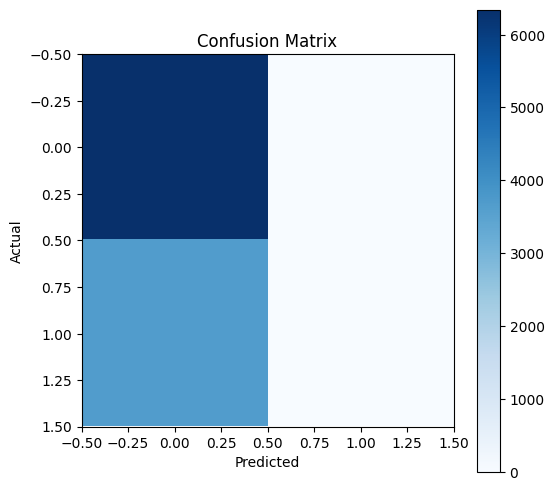

In [12]:
#running the logisitc regression with gradient descent

from sklearn.model_selection import StratifiedShuffleSplit 
from sklearn.linear_model import SGDClassifier



#setup
regularize_const = 0.0001
iterations = 150
cv = ShuffleSplit(n_splits = 1, test_size=0.2, random_state =3)
 
log_sgd = SGDClassifier(
    alpha=regularize_const,
    fit_intercept=True,
    l1_ratio=0.0,
    learning_rate='optimal',
    loss='log_loss',
    n_iter_no_change=iterations,
    n_jobs=-1,
    penalty='l2'

)

scl = StandardScaler()

#traing loop
for train_idx, test_idx in cv.split(X, y):
    log_sgd.fit(X_train_scaled, y[train_idx])
    X_train_scaled = scl.fit_transform(X[train_idx])
    X_test_scaled = scl.transform(X[test_idx])
    
    yhat = log_sgd.predict(X_test_scaled)

    conf = mt.confusion_matrix(y[test_idx], yhat)
    acc = mt.accuracy_score(y[test_idx], yhat)
print('Logistic Regression:', acc)

#plot cm
plt.figure(figsize=(6, 6))
plt.imshow(conf, cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### <u>Support Vector Machine with Important Features</u>

A Support Vector Machine classifier was trained next using the same selection of important features indentified earlier in the analysis to evaluate whether a non-linear model could improve classification performance. A 80/20 train-test split was performed using a shuffle-based cross validation strategy, and all the features were standardized before training. Additionally, the model was implemented using the radial basis function (RBF) kernel with a regularization parameter C = 0.5 and automatic gamma selection, allowing the classifier to learn non-linear decision boundaries. 

The resulting SVM achieved an accuracy of 99.2% which significantly outperformed both logistic regression models. Additionally, the confusion matrix had very few misclassifications, with only a small number of false positives and false negatives, indicating strong performance across both classes. Overall, these results demonstrated that the SVM model captures complex relationship more effectively than logistic regression. 

In [13]:
#SVM 
from sklearn.svm import SVC

#defining the top featues based on importance 
top_features = [
    'Communication_Skills',
    'Backlogs',
    'CGPA',
    'Coding_Skills',
    'Projects',
    'Certifications',
    'Aptitude_Test_Score'
]

df_top = df_encoded[top_features + ['Placement_Status']]

#define new x and y
y = df_top['Placement_Status'].values
X = df_top.drop(columns=['Placement_Status']).values

# CV
cv_object = ShuffleSplit(n_splits=1, test_size=0.2, random_state=3)

#fit the model
for train_idx, test_idx in cv_object.split(X, y):
    X_train = X[train_idx]
    y_train = y[train_idx]
    X_test = X[test_idx]
    y_test = y[test_idx]

    # Standardize
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)


#training SVM model
svm_clf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto')
svm_clf.fit(X_train_scaled, y_train)

#predict
y_hat = svm_clf.predict(X_test_scaled)

#Evaluate
accuracy = mt.accuracy_score(y_test, y_hat)
conf = mt.confusion_matrix(y_test, y_hat)

print('accuracy:', accuracy )
print(conf)

#look at support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

accuracy: 0.9923
[[6307   38]
 [  39 3616]]
(2602, 7)
(2602,)
[1304 1298]


### <u>Support Vector Machine with Linear </u>

Next a Support Vector Machine with a linear kernel was trained using the same subset of important features to evaluate whether a simple linear decision boundary is sufficient for the classifcation task. The linear SVM was configured with an 80/20 shuffle-based cross-validation strategy, and a regularization parameter of C = 0.5. The resulting model achieved an accuracy of 87.3% which is comparable to the performance of logistic regression models, but it is still lower than than the non-linear SVM with an RBF kernel. 

The confusion matrix shows a balanced distribution of false positives and false negatives. Additionally, the large number of support vectors suggest that many data points lie close to the decision boundary, which indicates that the relationshop between the features and target variable is not strictly linear. Therefore, these results indicated that a non-linear kernel is better suited for capturing complex patterns present in the dataset. 

In [14]:
#svm with linear kernel

#defining the top featues based on importance 
top_features = [
    'Communication_Skills',
    'Backlogs',
    'CGPA',
    'Coding_Skills',
    'Projects',
    'Certifications',
    'Aptitude_Test_Score'
]

df_top = df_encoded[top_features + ['Placement_Status']]

#define new x and y
y = df_top['Placement_Status'].values
X = df_top.drop(columns=['Placement_Status']).values

# CV
cv_object = ShuffleSplit(n_splits=1, test_size=0.2, random_state=3)

#fit the model
for train_idx, test_idx in cv_object.split(X, y):
    X_train = X[train_idx]
    y_train = y[train_idx]
    X_test = X[test_idx]
    y_test = y[test_idx]

    # Standardize
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)


#training SVM model
svm_clf = SVC(C=0.5, kernel='linear', degree=3, gamma='auto')
svm_clf.fit(X_train_scaled, y_train)

#predict
y_hat = svm_clf.predict(X_test_scaled)

#Evaluate3
accuracy = mt.accuracy_score(y_test, y_hat)
conf = mt.confusion_matrix(y_test, y_hat)

print('accuracy:', accuracy )
print(conf)

#look at support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

accuracy: 0.873
[[5682  663]
 [ 607 3048]]
(13228, 7)
(13228,)
[6615 6613]


### <u>Model Selection and Final Recommendation</u>

Several classification models were evaluated for predicting student placement stauts, including logistic regression and support vector machines with both linear and non-linear kernels. The logistic regression models performed consistently and provided interpretable results, while the SVM achieved a similar accuracy, indicating that some linear structure does exist in the data. However, the SVM with an RBF kernel outperformed all other models as it achieved the highest accuracy, and had the fewest misclassifications. This indicates that the relationship between student attributes and placement outcomes is non-linear. Therefore, based on these results, the RBF SVM is the perferred model for this task due to its high predicitive performance. 


## 2. Explaining the Difference Between Logistic Regression and Support Vector Machines 

### <u> Logistic Regression Overview </u>

The basic description of a Logistic Regression Model is it models the probability that an observation belongs to a certain class. It uses the logistic sigmoid function to map a linear combination of features to a probability. It is a classification model that is simple to implement and performs very well on linearly separable classes. It is actually one of the most widely used algorithms in industry because of its interpretability of features and their probabilistic relationship to the target class variable. You could think of using this algorithm when wanting to have a good interpretable model.

### <u> Support Vector Machines Overview </u>

SVM's is an extension of the perceptron algorithm where we originally minimized misclassification errors however with this extended version our optimization objective is to maximize the margin. The margin can be defined as the distance between the separating hyperplanes and the training examples that are closest to this hyperplane which are the so-called support vectors that define the boundary. It focuses on finding the decision boundary (hyperplane) that maximizes the margin between classes. You could think of using this algorithm when wanting the have to cleanest separation possible between classes. 

### <u>What are the advantages of each model for classification tasks?</U>

Binary Classifications with Probabilities:
- Logistic Regression is the best choice because it produces well calibrated probabilities and coefficients are directly interpretable. SVM outputs distances, not probabilities and probability calibration adds complexity and instability. 

Linearly Separable Classes:
- Both Logistic Regression and SVM are good however choosing Logistic Regression would be better for interpretability and faster training time. Choosing SVM would be better for slightly better margins/accuracy and has stronger performance for high dimensional data.

High Dimensional Sparse Data (Text/NLP/Many Features):
- SVM is the best since it is designed for high-dimensional spaces, less affected by the curse of dimensionality because it relies on support vectors that is directly related to the structure of the train data. Logistic Regression is still competitive but requires stronger regularization and can overfit without tuning.

Non-Linear Decision Boundaries:
- SVM is the best because it has the Kernel parameter which is also known as the kernel trick that allows the model to learn complex non-linear boundaries where as logistic regression requires manual feature engineering and polynomial expansion increases dimensionality fast which is hurtful to the logistic regression model.

Small to Medium Datasets:
- SVM is the best because margin maximization reduces overfitting and performs well with limited data. Logistic regression can overfit if regularization is weak and needs more data for stable probability estimates.

Large-Scale Production Systems:
- Logistic Regression is the best choice because they not only are memory efficient and scalable but also good for getting fast training and inference. Kernal SVM's do not scale well and training time grows quickly with data size.

Imbalanced Classification Problems:
- Best choice is logistic regression as it works naturally with class weights while as SVM is sensitive to margin distortion and requires careful tuning of C and class weights.

Multiclass Classification:
- Logistic Regression in most cases because it produces class probabilities that are both stable and interpretable. SVM's typically scale poorly with many classes.

### <u>Does one type of model offer superior performance over another (accuracy, training time, efficiency)?</u>

| Aspect | Logistic Regression | Support Vector Machines |
|----------|----------|----------|
| Training Speed |  <center> Fast </center> | <center> Slower (esp. with Kernal) </center> |
| Works with Large Datasets | <center> Yes </center> | <center> Kernal SVM's: No </center> |
| High Dimensional Data | <center> Good </center> | <center> Very Good </center> |
| Accuracy | <center> Good </center> | <center> Slightly Better </center> |
| Interpretability | <center> Better </center> | <center> Harder </center> |


### <u>Use Cases of Each Model</u>

Logistic Regression:
- You need interpretable coefficients/features
- Probabilities matter (e.g Risk Scores, Medical Decisions)
- Dataset is large and mostly linear
- You want a strong baseline model

Support Vector Machines:
- Accuracy is more important that interpretability
- Data is complex and possibly non-linear
- You have a medium-sized dataset
- Feature space is high dimensional (e.g Text, Many Features)

### <u>Which Model Best Suits our Data and Classification Task?</u>

To see what these models give us based on our data let us start by training a Logistic Regression Model and a Support Vector Machine on all 13 variables for our feature space.

In [15]:
import pandas as pd

df = pd.read_csv("../Student Placement Dataset/full_dataset.csv")

# All Feature Except Target
numeric_features = [
    'Age',
    'CGPA',
    'Internships',
    'Projects',
    'Coding_Skills',
    'Communication_Skills',
    'Aptitude_Test_Score',
    'Soft_Skills_Rating',
    'Certifications',
    'Backlogs'
]
categorical_features = [
    'Branch',
    'Degree',
    'Gender'
]

# Target Column
target_col = "Placement_Status"  # change if needed
X = df[numeric_features + categorical_features]

# Encode the target variable
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(df["Placement_Status"])

# Train/Test Split (80/20) ------------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y  # keeps class balance
)

# Preprocessing (Encoding + Scaling) ----------------------------------------------------------------------
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

# Logistic Regression --------------------------------------------------------------------------------------
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

log_reg_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])

log_reg_pipeline.fit(X_train, y_train)

y_pred_lr = log_reg_pipeline.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

# SVM Classifier -----------------------------------------------------------------------------------------
from sklearn.svm import SVC

svm_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", SVC(kernel="rbf", C=1.0, gamma="scale"))
])

svm_pipeline.fit(X_train, y_train)

y_pred_svm = svm_pipeline.predict(X_test)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

Logistic Regression Accuracy: 0.8666
              precision    recall  f1-score   support

           0       0.89      0.90      0.90      6375
           1       0.82      0.80      0.81      3625

    accuracy                           0.87     10000
   macro avg       0.86      0.85      0.85     10000
weighted avg       0.87      0.87      0.87     10000

SVM Accuracy: 0.9824
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      6375
           1       0.98      0.97      0.98      3625

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



Right off the bat we can see the accuracy is much higher on the Support Vector Machine then the Logistic Regression model and this is because of what we said before with SVM's goal of having the best separation possible between classes which in turn results in a higher accuracy when running our test set. Also because of our 13-dimension feature space the SVM handles more complex and possibly non-linear data more effectively than Logistic Regression. 

We can visualize the decision boundary of both classifiers by projecting the 13 features onto a 2-D subspace via PCA using 2 primary component for a better explanation of the results.

In [16]:
# Transform your data (after preprocessing)
from sklearn.decomposition import PCA

# Use the SAME preprocessing as your model
X_train_processed = log_reg_pipeline.named_steps["preprocessor"].fit_transform(X_train)

# Reduce to 2D
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_processed)

# Print class order for interpretation of visuals
print("Classes in order:", le.classes_)
for i, cls in enumerate(le.classes_):
    print(f"{cls} --> {i}")

Classes in order: ['Not Placed' 'Placed']
Not Placed --> 0
Placed --> 1


In [18]:
# Plot decision regions for Logistic Regression in PCA space
from mlxtend.plotting.decision_regions import plot_decision_regions
import matplotlib.pyplot as plt

# Train a classifier on PCA space
from sklearn.linear_model import LogisticRegression

lr_pca = LogisticRegression(max_iter=1000)
lr_pca.fit(X_train_pca, y_train)

# Plotting decision regions for Logistic Regression in PCA space
plot_decision_regions(
    X=X_train_pca,
    y=y_train.values if hasattr(y_train, "values") else y_train,
    clf=lr_pca
)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(loc="upper right")
plt.title("Logistic Regression Decision Boundary (PCA Projection)")
plt.show()

ModuleNotFoundError: No module named 'mlxtend'

This is the calculated decision boundary for the Logistic Regression Model. As we can see the shape of the line of separation between classes is not linear, in fact the two classes are very close to each other, but Logistic Regression forces a linear boundary leading to some incorrect classifications. However, this model is more reliable as it gives a better probabilistic idea on unseen subjects that are not included in our test data. This makes this model more interpretable for the factors that affect the probability of one being placed in a job. Also notice this model rendered quite fast.

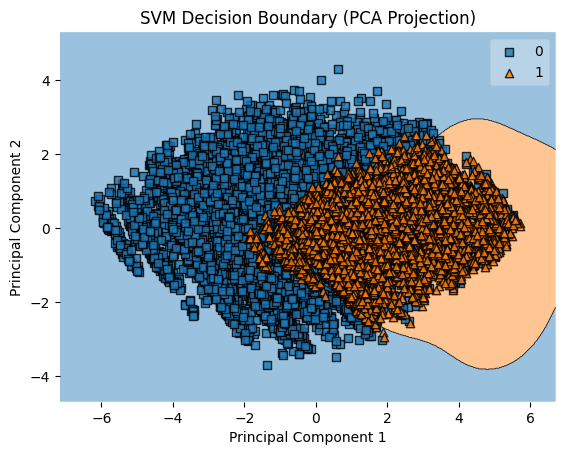

In [ ]:
# Plot decision regions for SVM in PCA space
from sklearn.svm import SVC

# Train a classifier on PCA space
svm_pca = SVC(kernel="rbf", C=1.0, gamma="scale")
svm_pca.fit(X_train_pca, y_train)

# Plotting decision regions for SVM in PCA space
plot_decision_regions(
    X=X_train_pca,
    y=y_train.values if hasattr(y_train, "values") else y_train,
    clf=svm_pca
)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("SVM Decision Boundary (PCA Projection)")
plt.show()

This is the calculated decision boundary for the Support Vector Machine. We can see the boundary follows the curved shape of the separation between the classes. As we said before we would use an SVM if we wanted to have the cleanest separation possible. This shows the decision boundary being formed from the support vectors that follow the subset of points that lay on the hyperplane boundaries of both classes that have the highest margin of separation. This clean separation leads to more accurate classifications, however, is less reliable for unseen test sets so it is less interpretable, almost too perfect which defines the term overfitting. Also notice the render time for this model took significantly longer indicating what we said previously about long training times with SVM's. 

### <u>Conclusion on What Model to Select for Our Classification Task</u>

For our dataset and classification task, it really depends on what insight we want from our output. We could either go down the path of using Logistic Regression because of it's high interpretability and curiosity to find which factors most influence job placement outcomes and is less computationally expensive. Or choosing a support vector machine to get a more accurate model with respect to our test dataset, that is able to handle a higher dimensional training set like the Student Placement data we are working with but is computationally more expensive.

## 3. Interpreting Feature Importance Using Logistic Regression

In this section, we use logistic regression to analyze the importance of different student-related features in predicting placement outcomes. Logistic regression models the log-odds of a binary outcome as a linear combination of input features, allowing direct interpretation of feature coefficients.

In [ ]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [ ]:
df = pd.read_csv("full_dataset.csv")
df.head()

### <u>Logistic Regression Overview</u>

Logistic regression models the probability of a binary outcome using the following relationship:

\[
\log \left(\frac{p}{1 - p}\right) = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_k x_k
\]

Each coefficient represents the change in the log-odds of being placed associated with a one-unit increase in the corresponding feature, holding all other features constant.


In [ ]:
y = df["Placement_Status"]

X = df.drop(columns=["Placement_Status", "Student_ID"])

X.dtypes

### <u>Feature Preprocessing</u>

The dataset contains both numerical and categorical variables. Since logistic regression requires numerical inputs, categorical variables such as Gender, Degree, and Branch are converted into binary indicators using one-hot encoding.

The identifier column `Student_ID` is removed because it does not contain predictive information.

In [ ]:
X_encoded = pd.get_dummies(X, drop_first=True)
X_encoded

### <u>Feature Scaling</u>

All features are standardized using z-score normalization. Standardization ensures that coefficient magnitudes are directly comparable and reflect true relative importance rather than differences in feature scale.

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)
X_scaled

In [ ]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_scaled, y)

### <u>Interpreting Logistic Regression Coefficients</u>

The learned coefficients from the logistic regression model are analyzed to determine feature importance. Features with larger absolute coefficient values have a stronger influence on placement probability.

Odds ratios are computed by exponentiating the coefficients to provide a more intuitive interpretation.

In [ ]:
coef_df = pd.DataFrame({
    "Feature": X_encoded.columns,
    "Coefficient": log_reg.coef_[0]
})

coef_df["Absolute_Coefficient"] = coef_df["Coefficient"].abs()
coef_df["Odds_Ratio"] = np.exp(coef_df["Coefficient"])

coef_df = coef_df.sort_values(by="Absolute_Coefficient", ascending=False)
coef_df

### <u>Feature Importance Analysis</u>

The most influential feature in predicting placement is **Backlogs**, which has the largest absolute coefficient and a strong negative effect. Its odds ratio of approximately 0.16 indicates that an increase in backlogs significantly reduces the likelihood of placement.

**Communication Skills** is the strongest positive predictor, with an odds ratio greater than 5. This suggests that students with stronger communication skills are substantially more likely to be placed.

Other positively contributing features include **Certifications**, **CGPA**, and **Coding Skills**, all of which align with real-world hiring expectations emphasizing academic performance and job readiness.

Categorical variables such as Degree and Branch exhibit relatively small coefficients, indicating that once skills and performance metrics are considered, academic background plays a lesser role in placement outcomes.


### <u>Why Some Variables Are More Important</u>

Variables such as Backlogs, Communication Skills, and Certifications are more important because they directly capture employability and academic consistency. These features provide strong, independent signals that employers consider during recruitment.

In contrast, demographic and categorical variables contribute less unique information once performance-related factors are included in the model. Logistic regression naturally emphasizes features that reduce uncertainty in predicting the outcome, resulting in larger coefficients for variables with higher predictive power.


## 3. Analyzing Insight from Support Vectors from SVM Model